# `mdmm` tutorial
The purpose of this notebook is to guide you to train a model with a loss function of several parameters in a proper mathematical way. The idea comes from the paper [Constrained Differential Optimization](https://papers.nips.cc/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf), and the implementation from the [mdmm package Github](https://github.com/crowsonkb/mdmm)

The guide is best illustrated through the **[VICReg](https://arxiv.org/abs/2105.04906)** example where your input is split into two views and you are asked to minimize three loss terms: `variance`, `invariance` and `covariance`.

In [1]:
! pip install mdmm

In [2]:
import warnings
import numpy as np
import mdmm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, GATConv
from torch_geometric.nn.conv import GravNetConv

warnings.simplefilter("ignore", UserWarning)

# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA A10


In [3]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed Jul 19 21:11:23 2023
Driver Version                            : 515.65.01
CUDA Version                              : 11.7

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Product Name                          : NVIDIA A10
    Product Brand                         : NVIDIA
    Product Architecture                  : Ampere
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 1565021003080
    GPU UUID          

Load a processed `.pt` clic file.

In [4]:
data = torch.load("/../ssl-jet-vol-v2/toptagging/train/processed/data_0.pt")
print(f"num of clic events {len(data)}")

num of clic events 100001


In [5]:
# build a data loader
batch_size = 128

loader = DataLoader(data, batch_size, shuffle=True)
for batch in loader:
    print(f"A single event: \n {batch}")
    break

input_dim = batch.x.shape[-1]

A single event: 
 DataBatch(x=[6214, 7], y=[128], batch=[6214], ptr=[129])


# Preparation

In [6]:
def translate_jets(batch, width=1.0, device='cpu'):
    width = 1.0
    bb = batch.clone()
    bb = bb.to("cpu")
    X = bb.x.numpy()
    ptp_eta = np.ptp(X[:,0], axis=-1, keepdims=True)
    ptp_phi = np.ptp(X[:,1], axis=-1, keepdims=True)
    low_eta  = -width*ptp_eta
#     print(f"low eta: {low_eta}")
    high_eta = +width*ptp_eta
#     print(f"high eta: {high_eta}")
    low_phi = np.maximum(-width*ptp_phi, -np.pi-np.min(X[:,1]).reshape(ptp_phi.shape))
#     print(f"low phi: {low_phi}")
    high_phi = np.minimum(+width*ptp_phi, +np.pi-np.max(X[:,1]).reshape(ptp_phi.shape))
#     print(f"high phi: {high_phi}")
    shift_eta_batch = np.random.uniform(low=low_eta, high=high_eta, size=(bb.y.shape[0], 1))  
    shift_phi_batch = np.random.uniform(low=low_phi, high=high_phi, size=(bb.y.shape[0], 1))  
    
    # To make sure that the components of each jet get shifted by the same amount
    for i in range(len(bb)):
        X_jet = bb[i].x.numpy()
        shift_eta_jet = np.ones((X_jet.shape[0], 1)) * shift_eta_batch[i]
        shift_phi_jet = np.ones((X_jet.shape[0], 1)) * shift_phi_batch[i]
        if i == 0:
            shift_eta = shift_eta_jet
            shift_phi = shift_phi_jet
        else:
            shift_eta = np.concatenate((shift_eta, shift_eta_jet))
            shift_phi = np.concatenate((shift_phi, shift_phi_jet))

    shift = np.hstack((shift_eta, shift_phi, np.zeros((X.shape[0], 5))))
    new_X = X + shift
    new_X = torch.tensor(new_X).to(device)
    bb.x = new_X
    return bb.to(device)

In [7]:
def rotate_jets(batch, device):
    bb = batch.clone()
    bb = bb.to("cpu")
    rot_angle = np.random.rand(len(bb))*2*np.pi
#     print(rot_angle)
    c = np.cos(rot_angle)
    s = np.sin(rot_angle)
    o = np.ones_like(rot_angle)
    z = np.zeros_like(rot_angle)
    rot_matrix = np.array([[z, c, -s], [z, s, c], [o, z, z]])  # (3, 3, 100)
    rot_matrix = rot_matrix.transpose(2,0,1)  # (100, 3, 3)

    for i in range(len(bb)):
        x_ = bb[i].x[:,:3]
        new_x = np.einsum('ij,jk', bb[i].x[:,:3], rot_matrix[i])  # this is somehow (pT, eta', phi')
        new_x[:, [0,2]] = new_x[:, [2, 0]] 
        new_x[:, [0,1]] = new_x[:, [1, 0]] # now (phi', eta', pT)
        
        if i == 0:
            new_X = new_x
        else:
            new_X = np.concatenate((new_X, new_x), axis=0)

    new_X = torch.tensor(new_X).to(device)
    bb.x[:,:3] = new_X
    return bb.to(device)

In [8]:
def augmentation(batch, device="cpu"):
    """
    Takes events of the form Batch() and applies a series of augmentations. 
    The output will have the same shape as the input
    """
    batch_aug = translate_jets(batch, device=device)
    batch_aug = rotate_jets(batch_aug, device=device)
    return batch_aug

In [9]:
def event_augmentation(batch, device="cpu"):
    """
    Takes events of the form Batch() and splits them into two Batch() objects representing the two views.

    In this example, the two views are translated and then rotated by different amounts
    """
    view1 = augmentation(batch, device=device)
    view2 = augmentation(batch, device=device)

    return view1, view2

In [10]:
# view1, view2 = event_augmentation(batch, device)
# print(f"view1: {view1}")
# print(f"view2: {view2}")

In [11]:
# view1.x

In [12]:
# print(view2[10])

In [13]:
# print(view1[0].x[:3])

# Setup the VICReg model (Transformer-based)
https://github.com/bmdillon/JetCLR/blob/main/scripts/modules/transformer.py

In [14]:
class Transformer(nn.Module):
    # define and intialize the structure of the neural network
    def __init__(
        self,
        input_dim=7,
        model_dim=1000,
        output_dim=1000,
        n_heads=4,
        dim_feedforward=1000,
        n_layers=4,
        learning_rate=0.00005,
        n_head_layers=2,
        head_norm=False,
        dropout=0.1,
        opt="adam",
    ):
        super().__init__()
        # define hyperparameters
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.output_dim = output_dim
        self.n_heads = n_heads
        self.dim_feedforward = dim_feedforward
        self.n_layers = n_layers
        self.learning_rate = learning_rate
        self.n_head_layers = n_head_layers
        self.head_norm = head_norm
        self.dropout = dropout
        # define subnetworks
        self.embedding = nn.Linear(input_dim, model_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                model_dim, n_heads, dim_feedforward=dim_feedforward, dropout=dropout
            ),
            n_layers,
        )
        # head_layers have output_dim
        if n_head_layers == 0:
            self.head_layers = []
        else:
            if head_norm:
                self.norm_layers = nn.ModuleList([nn.LayerNorm(model_dim)])
            self.head_layers = nn.ModuleList([nn.Linear(model_dim, output_dim)])
            for i in range(n_head_layers - 1):
                if head_norm:
                    self.norm_layers.append(nn.LayerNorm(output_dim))
                self.head_layers.append(nn.Linear(output_dim, output_dim))
        # option to use adam or sgd
        if opt == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        if opt == "sgdca" or opt == "sgdslr" or opt == "sgd":
            self.optimizer = torch.optim.SGD(
                self.parameters(), lr=self.learning_rate, momentum=0.9
            )

    def forward(self, view1, view2, mask=None, mult_reps=False):
        """
        the two views are shaped like DataBatch(x=[12329, 7], y=[256], batch=[12329], ptr=[257])
        transformer expects (sequence_length, feature_number) so we don't need to transpose
        """
        view1_representations, view2_representations = [], []
        assert len(view1) == len(view2)
        # produce one representation per jet
        for i in range(len(view1)):
            jet1 = view1[i]
            jet2 = view2[i]
            # make a copy
            x_1 = jet1.x + 0.0
            x_2 = jet2.x + 0.0
            # cast to torch.float32 to prevent RuntimeError: mat1 and mat2 must have the same dtype
            x_1 = x_1.to(torch.float32)
            x_2 = x_2.to(torch.float32)
            # embedding
            x_1 = self.embedding(x_1)
            x_2 = self.embedding(x_2)
            # transformer
            x_1 = self.transformer(x_1, mask=mask)
            x_2 = self.transformer(x_2, mask=mask)
            # sum over sequence dim
            # (batch_size, model_dim)
            x_1 = x_1.sum(0)
            x_2 = x_2.sum(0)
            # head
            x_1 = self.head(x_1, mult_reps)
            x_2 = self.head(x_2, mult_reps)
            # append to representations list
            view1_representations.append(x_1)
            view2_representations.append(x_2)
        
        return torch.stack(view1_representations), torch.stack(view2_representations)

    def head(self, x, mult_reps):
        """
        calculates output of the head if it exists, i.e. if n_head_layer>0
        returns multiple representation layers if asked for by mult_reps = True
        input:  x shape=(batchsize, model_dim)
                mult_reps boolean
        output: reps shape=(batchsize, output_dim)                  for mult_reps=False
                reps shape=(batchsize, number_of_reps, output_dim)  for mult_reps=True
        """
        relu = nn.ReLU()
        # return representations from multiple layers for evaluation
        if mult_reps == True:
            if self.n_head_layers > 0:
                reps = torch.empty(x.shape[0], self.n_head_layers + 1, self.output_dim)
                reps[:, 0] = x
                for i, layer in enumerate(self.head_layers):
                    # only apply layer norm on head if chosen
                    if self.head_norm:
                        x = self.norm_layers[i](x)
                    x = relu(x)
                    x = layer(x)
                    reps[:, i + 1] = x
                # shape (n_head_layers, output_dim)
                return reps
            # no head exists -> just return x in a list with dimension 1
            else:
                reps = x[:, None, :]
                # shape (batchsize, 1, model_dim)
                return reps
        # return only last representation for contrastive loss
        else:
            for i, layer in enumerate(
                self.head_layers
            ):  # will do nothing if n_head_layers is 0
                if self.head_norm:
                    x = self.norm_layers[i](x)
                x = relu(x)
                x = layer(x)
            # shape either (model_dim) if no head, or (output_dim) if head exists
            return x

In [15]:
class VICReg(nn.Module):
    def __init__(self, encoder, decoder):
        super(VICReg, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.augmentation = event_augmentation
        self.device = device

    def forward(self, event):
        # seperate the two views
        view1, view2 = self.augmentation(event, self.device)

        # encode to retrieve the representations
        view1_representations, view2_representations = self.encoder(view1, view2)
#         print(f"view 1 representations: {view1_representations}")
#         print(f"view 2 representations: {view2_representations}")

        # simple MLP decoder
        view1_embeddings = self.decoder(view1_representations)
        view2_embeddings = self.decoder(view2_representations)

        # global pooling to be able to compute a loss between views of different dimensionalities
#         view1_embeddings = global_mean_pool(view1_embeddings, view1.batch)
#         view2_embeddings = global_mean_pool(view2_embeddings, view2.batch)

        return view1_embeddings, view2_embeddings


class ENCODER(nn.Module):
    """The Encoder part of VICReg which attempts to learn useful latent representations of the two views."""

    def __init__(
        self,
        input_dim,
        width=126,
        embedding_dim=34,
        num_convs=2,
    ):
        super(ENCODER, self).__init__()

        self.act = nn.ELU

        # 1. same MLP for each view
        self.nn1 = nn.Sequential(
            nn.Linear(input_dim, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, embedding_dim),
        )
        self.nn2 = self.nn1

        # 2. same GNN for each view
        self.convs = nn.ModuleList()
        for i in range(num_convs):
            self.convs.append(
                GravNetConv(
                    embedding_dim,
                    embedding_dim,
                    space_dimensions=4,
                    propagate_dimensions=22,
                    k=8,
                )
            )

    def forward(self, view1, view2):
        view1_representations = self.nn1(view1.x.float())
        view2_representations = self.nn2(view2.x.float())

        # perform a series of graph convolutions
        for num, conv in enumerate(self.convs):
            view1_representations = conv(view1_representations, view1.batch)
            view2_representations = conv(view2_representations, view2.batch)

        return view1_representations, view2_representations


class DECODER(nn.Module):
    """The Decoder part of VICReg which attempts to expand the learned latent representations
    of the two views into a space where a loss can be computed."""

    def __init__(
        self,
        embedding_dim=34,
        width=126,
        output_dim=200,
    ):
        super(DECODER, self).__init__()

        self.act = nn.ELU

        # DECODER
        self.expander = nn.Sequential(
            nn.Linear(embedding_dim, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, output_dim),
        )

    def forward(self, x):
        return self.expander(x)


In [16]:
# GravNet based
# vicreg_encoder = ENCODER(input_dim, embedding_dim=34)
# vicreg_decoder = DECODER(embedding_dim=34, output_dim=200)

# Transformer based
vicreg_encoder = Transformer()
vicreg_decoder = DECODER(embedding_dim=1000, output_dim=200)

vicreg = VICReg(vicreg_encoder, vicreg_decoder)
vicreg.to(device)

VICReg(
  (encoder): Transformer(
    (embedding): Linear(in_features=7, out_features=1000, bias=True)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1000, out_features=1000, bias=True)
          )
          (linear1): Linear(in_features=1000, out_features=1000, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1000, out_features=1000, bias=True)
          (norm1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1000, out_features=

# Setup the loss terms

In [17]:
def off_diagonal(x):
    """Copied from VICReg paper github https://github.com/facebookresearch/vicreg/"""
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class CovLoss(nn.Module):
    def forward(self, view1, view2):
        N = view1.size(0)  # batch size
        D = view1.size(1)  # dim of representations

        view1 = view1 - view1.mean(dim=0)
        view2 = view2 - view2.mean(dim=0)

        cov_view1 = (view1.T @ view1) / (N - 1)
        cov_view2 = (view2.T @ view2) / (N - 1)

        loss = off_diagonal(cov_view1).pow_(2).sum().div(D) + off_diagonal(cov_view2).pow_(2).sum().div(D)
        return loss


class VarLoss(nn.Module):
    def forward(self, view1, view2):
        view1 = view1 - view1.mean(dim=0)
        view2 = view2 - view2.mean(dim=0)

        # variance loss
        std_view1 = torch.sqrt(view1.var(dim=0) + 1e-10)
        std_view2 = torch.sqrt(view2.var(dim=0) + 1e-10)

        loss = torch.mean(F.relu(1 - std_view1)) / 2 + torch.mean(F.relu(1 - std_view2)) / 2
        return loss

In [18]:
crit_invar = nn.MSELoss()
crit_var = VarLoss()
crit_cov = CovLoss()

max_var = 1e-5 * batch_size
max_cov = 50 * batch_size

constraints = []
constraints.append(mdmm.MaxConstraint(lambda: crit_var(view1_embeddings, view2_embeddings), max_var))
constraints.append(mdmm.MaxConstraint(lambda: crit_cov(view1_embeddings, view2_embeddings), max_cov, scale=1e4))

mdmm_module = mdmm.MDMM(constraints)
optimizer = mdmm_module.make_optimizer(vicreg.parameters(), lr=1e-4)

# Run a training loop

In [19]:
losses_inv, losses_var, losses_cov, losses_reg = [], [], [], []

for i, batch in enumerate(loader):
    print(f"batch {i}")
    # run VICReg forward pass to get the embeddings
    view1_embeddings, view2_embeddings = vicreg(batch.to(device))
    print(f"view1_embeddings size: {view1_embeddings.size()}")

    # compute the invariance loss which is contrained by the other loss terms
    loss = batch_size * crit_invar(view1_embeddings, view2_embeddings)
#     print(f"invariance loss: {loss:.2f}")
    losses_inv.append(loss.detach().item())
    loss_var = batch_size * crit_var(view1_embeddings, view2_embeddings)
#     print(f"variance loss: {loss_var:.2f}")
    losses_var.append(loss_var.detach().item())
    loss_cov = batch_size * crit_cov(view1_embeddings, view2_embeddings)
#     print(f"covariance loss: {loss_cov:.2f}")
    losses_cov.append(loss_cov.detach().item())
#     print(f"max var: {max_var * 1e4}")
#     print(f"max cov: {max_cov * 1e4}")

    mdmm_return = mdmm_module(loss)

    # backprop
    for param in vicreg.parameters():
        param.grad = None
    mdmm_return.value.backward()
#     print(mdmm_return)

    optimizer.step()
#     print(f"constrained invariance loss: {loss.detach():.2f}")
    print(f"constrained invariance loss: {loss.detach():.2f}")
    losses_reg.append(loss.detach().item())

    if i == 100:
        break
#     print("-----------")

view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 9682.63
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 8885.83
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 14480.33
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 8904.89
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 6962.13
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 5660.12
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 5219.75
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 4488.83
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 3830.41
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 3981.82
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 2925.83
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 2705.58
vie

view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 1791.62
view1_embeddings size: torch.Size([128, 200])
constrained invariance loss: 1141.43


In [20]:
print(f"view1_embeddings size: {view1_embeddings.size()}")

view1_embeddings size: torch.Size([128, 200])


In [21]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed Jul 19 21:15:27 2023
Driver Version                            : 515.65.01
CUDA Version                              : 11.7

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Product Name                          : NVIDIA A10
    Product Brand                         : NVIDIA
    Product Architecture                  : Ampere
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 1565021003080
    GPU UUID          

In [22]:
import matplotlib
import matplotlib.pyplot as plt
# plt.plot(losses)

In [23]:
print(f"max var * 1e4: {max_var * 1e4}")
print(f"max cov * 1e4: {max_cov * 1e4}")

max var * 1e4: 12.8
max cov * 1e4: 64000000.0


Text(0.5, 1.0, 'Unconstrained Invariance loss * 1e4')

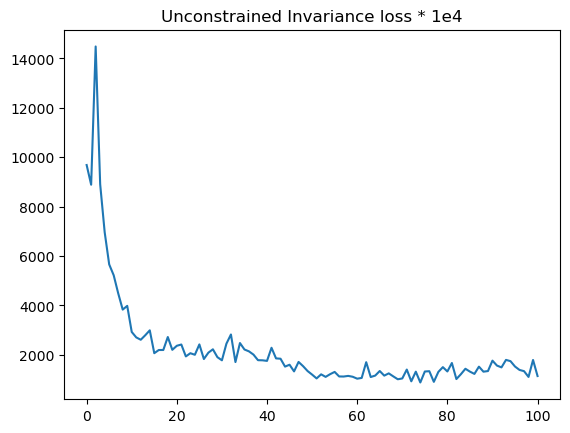

In [24]:
plt.plot(losses_inv)
plt.title("Unconstrained Invariance loss")

Text(0.5, 1.0, 'Variance loss * 1e4')

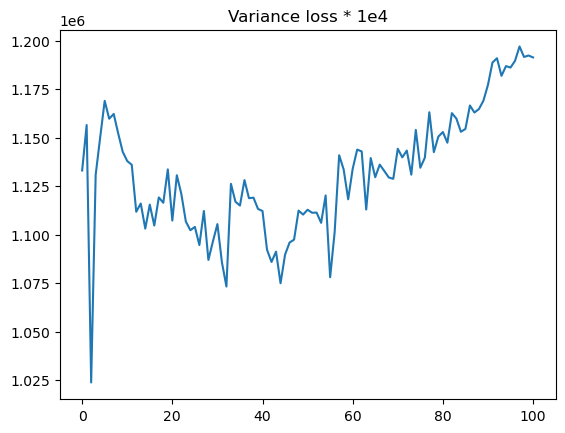

In [25]:
plt.plot(losses_var)
plt.title("Variance loss")

Text(0.5, 1.0, 'Covariance loss * 1e4')

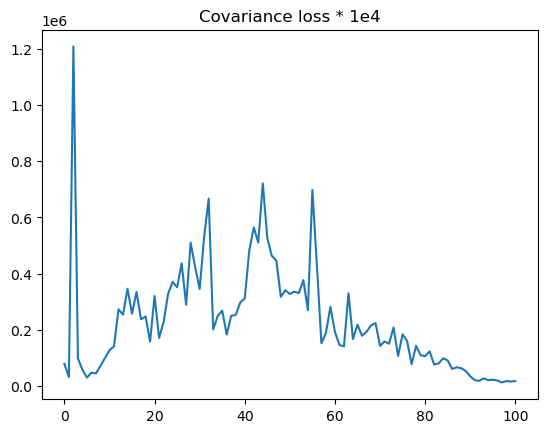

In [26]:
plt.plot(losses_cov)
plt.title("Covariance loss")

Text(0.5, 1.0, 'Constrained Invariance loss * 1e4')

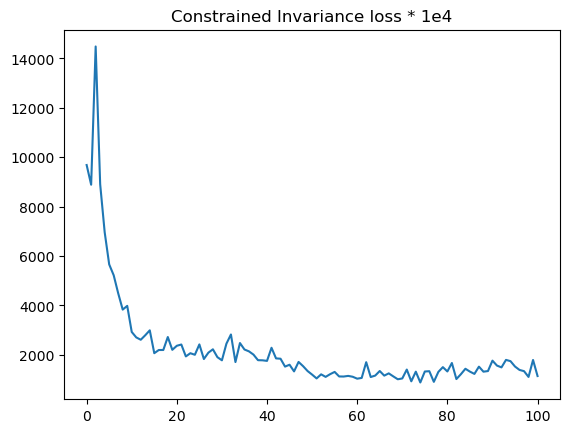

In [27]:
plt.plot(losses_reg)
plt.title("Constrained Invariance loss")